In [1]:

import os
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
# Disable eager execution and GPU (as in the example)
tf.compat.v1.disable_eager_execution()
tf.config.set_visible_devices([], 'GPU') 


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    return x

def predict(images):
    return model.predict(images)

2025-02-22 12:46:15.232873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 12:46:15.281848: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 12:46:15.282928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-22 12:46:16.054345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load InceptionV3 model

In [2]:
# Load pre-trained InceptionV3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2025-02-22 12:46:23.536362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-02-22 12:46:24.023943: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_84/beta/Assign' id:5014 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_84/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_84/beta, batch_normalization_84/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Select image to generate the explanation

In [3]:
# Replace with your image path
img_path = 'street_sign.jpg' 

# Load and preprocess the image
processed_image = preprocess_image(img_path)

# Get model predictions
preds = predict(processed_image)
decoded_preds = decode_predictions(preds)[0]

print("Top 5 predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_preds):
    print(f"{i + 1}: {label} ({score:.2f})")

/home/ubuntu/setup/ai-sec-env/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-02-22 12:46:25.948373: W tensorflow/c/c_api.cc:304] Operation '{name:'predictions/Softmax' id:5621 op device:{requested: '', assigned: ''} def:{{{node predictions/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Top 5 predictions:
1: street_sign (0.98)
2: pole (0.01)
3: traffic_light (0.00)
4: parking_meter (0.00)
5: mailbox (0.00)


### Create LIME Image explainer

In [4]:
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(processed_image[0].astype('double'), 
                                         predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualize explanation for the top predicted label

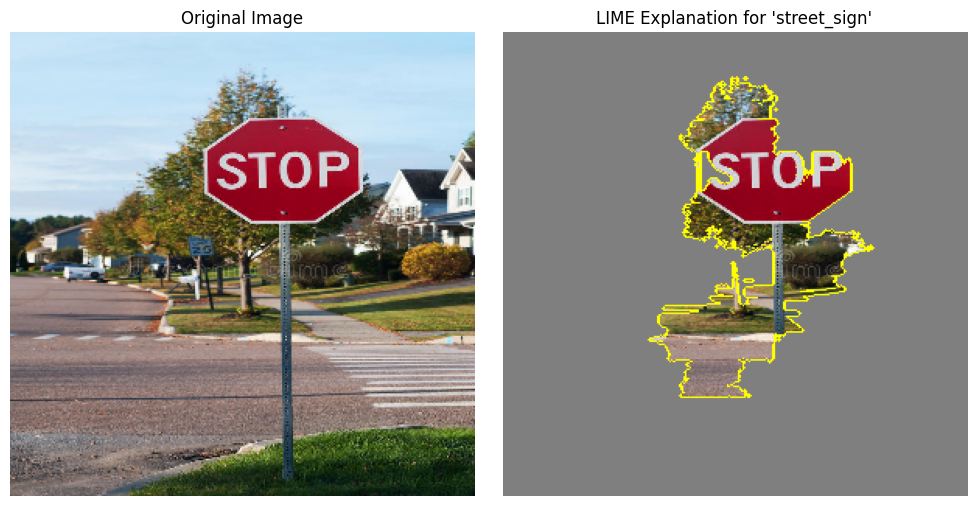

In [5]:
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(processed_image[0] / 2 + 0.5)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME Explanation for '{decoded_preds[0][1]}'")
plt.axis('off')

plt.tight_layout()
plt.show()
